# Train review analysis

The goal is to evaluate the new train schedules. We would like to know what people are discussing and what they could change to improve their service. 

Review data is from Trustpilot.com. It consists of about 2000 reviews of various UK train companies. The data is stored in a json file and contains the comment itself, when it was submitted, to which site it was submitted and the review score the user gave. 

The objective of this task is to extract the topics that people are talking about. Use whichever tools you feel are appropriate for the task, given the time available. Please be sure to include sufficient comments and discussion in your output to enable us to understand your thinking as you tackle this assignment.  

  Tasks
1. Extract the main topics people are talking about. 
2. Analyse how the topics changed over time. Do you see a difference in the topics or their frequency?

Discussions:
  a discussion of findings, which may include any of the following:
- What were the main topics in the data, were they different across the various companies? 
-  Do you see change of topics over time? 
- What other sources could be gathered to help answer the research question

In [ ]:
import pandas as pd
import warnings
import re
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
from numpy.random import multinomial
from numpy import log, exp
from numpy import argmax
import json

class MovieGroupProcess:
    def __init__(self, K=8, alpha=0.1, beta=0.1, n_iters=30):
        '''
        A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to
        describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the
        clustering short text documents.
        Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
        Imagine a professor is leading a film class. At the start of the class, the students
        are randomly assigned to K tables. Before class begins, the students make lists of
        their favorite films. The teacher reads the role n_iters times. When
        a student is called, the student must select a new table satisfying either:
            1) The new table has more students than the current table.
        OR
            2) The new table has students with similar lists of favorite movies.
        :param K: int
            Upper bound on the number of possible clusters. Typically many fewer
        :param alpha: float between 0 and 1
            Alpha controls the probability that a student will join a table that is currently empty
            When alpha is 0, no one will join an empty table.
        :param beta: float between 0 and 1
            Beta controls the student's affinity for other students with similar interests. A low beta means
            that students desire to sit with students of similar interests. A high beta means they are less
            concerned with affinity and are more influenced by the popularity of a table
        :param n_iters:
        '''
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.n_iters = n_iters

        # slots for computed variables
        self.number_docs = None
        self.vocab_size = None
        self.cluster_doc_count = [0 for _ in range(K)]
        self.cluster_word_count = [0 for _ in range(K)]
        self.cluster_word_distribution = [{} for i in range(K)]

    @staticmethod
    def from_data(K, alpha, beta, D, vocab_size, cluster_doc_count, cluster_word_count, cluster_word_distribution):
        '''
        Reconstitute a MovieGroupProcess from previously fit data
        :param K:
        :param alpha:
        :param beta:
        :param D:
        :param vocab_size:
        :param cluster_doc_count:
        :param cluster_word_count:
        :param cluster_word_distribution:
        :return:
        '''
        mgp = MovieGroupProcess(K, alpha, beta, n_iters=30)
        mgp.number_docs = D
        mgp.vocab_size = vocab_size
        mgp.cluster_doc_count = cluster_doc_count
        mgp.cluster_word_count = cluster_word_count
        mgp.cluster_word_distribution = cluster_word_distribution
        return mgp

    @staticmethod
    def _sample(p):
        '''
        Sample with probability vector p from a multinomial distribution
        :param p: list
            List of probabilities representing probability vector for the multinomial distribution
        :return: int
            index of randomly selected output
        '''
        return [i for i, entry in enumerate(multinomial(1, p)) if entry != 0][0]

    def fit(self, docs, vocab_size):
        '''
        Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return: list of length len(doc)
            cluster label for each document
        '''
        alpha, beta, K, n_iters, V = self.alpha, self.beta, self.K, self.n_iters, vocab_size

        D = len(docs)
        self.number_docs = D
        self.vocab_size = vocab_size

        # unpack to easy var names
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution
        cluster_count = K
        d_z = [None for i in range(len(docs))]

        # initialize the clusters
        for i, doc in enumerate(docs):

            # choose a random  initial cluster for the doc
            z = self._sample([1.0 / K for _ in range(K)])
            d_z[i] = z
            m_z[z] += 1
            n_z[z] += len(doc)

            for word in doc:
                if word not in n_z_w[z]:
                    n_z_w[z][word] = 0
                n_z_w[z][word] += 1

        for _iter in range(n_iters):
            total_transfers = 0

            for i, doc in enumerate(docs):

                # remove the doc from it's current cluster
                z_old = d_z[i]

                m_z[z_old] -= 1
                n_z[z_old] -= len(doc)

                for word in doc:
                    n_z_w[z_old][word] -= 1

                    # compact dictionary to save space
                    if n_z_w[z_old][word] == 0:
                        del n_z_w[z_old][word]

                # draw sample from distribution to find new cluster
                p = self.score(doc)
                z_new = self._sample(p)

                # transfer doc to the new cluster
                if z_new != z_old:
                    total_transfers += 1

                d_z[i] = z_new
                m_z[z_new] += 1
                n_z[z_new] += len(doc)

                for word in doc:
                    if word not in n_z_w[z_new]:
                        n_z_w[z_new][word] = 0
                    n_z_w[z_new][word] += 1

            cluster_count_new = sum([1 for v in m_z if v > 0])
            print("In stage %d: transferred %d clusters with %d clusters populated" % (
            _iter, total_transfers, cluster_count_new))
            if total_transfers == 0 and cluster_count_new == cluster_count and _iter>25:
                print("Converged.  Breaking out.")
                break
            cluster_count = cluster_count_new
        self.cluster_word_distribution = n_z_w
        return d_z

    def score(self, doc):
        '''
        Score a document
        Implements formula (3) of Yin and Wang 2014.
        http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
        :param doc: list[str]: The doc token stream
        :return: list[float]: A length K probability vector where each component represents
                              the probability of the document appearing in a particular cluster
        '''
        alpha, beta, K, V, D = self.alpha, self.beta, self.K, self.vocab_size, self.number_docs
        m_z, n_z, n_z_w = self.cluster_doc_count, self.cluster_word_count, self.cluster_word_distribution

        p = [0 for _ in range(K)]

        #  We break the formula into the following pieces
        #  p = N1*N2/(D1*D2) = exp(lN1 - lD1 + lN2 - lD2)
        #  lN1 = log(m_z[z] + alpha)
        #  lN2 = log(D - 1 + K*alpha)
        #  lN2 = log(product(n_z_w[w] + beta)) = sum(log(n_z_w[w] + beta))
        #  lD2 = log(product(n_z[d] + V*beta + i -1)) = sum(log(n_z[d] + V*beta + i -1))

        lD1 = log(D - 1 + K * alpha)
        doc_size = len(doc)
        for label in range(K):
            lN1 = log(m_z[label] + alpha)
            lN2 = 0
            lD2 = 0
            for word in doc:
                lN2 += log(n_z_w[label].get(word, 0) + beta)
            for j in range(1, doc_size +1):
                lD2 += log(n_z[label] + V * beta + j - 1)
            p[label] = exp(lN1 - lD1 + lN2 - lD2)

        # normalize the probability vector
        pnorm = sum(p)
        pnorm = pnorm if pnorm>0 else 1
        return [pp/pnorm for pp in p]

    def choose_best_label(self, doc):
        '''
        Choose the highest probability label for the input document
        :param doc: list[str]: The doc token stream
        :return:
        '''
        p = self.score(doc)
        return argmax(p),max(p)

In [3]:
df=pd.read_json("train_reviews.json")

<h2> Data Pre-processing </h2>

In [4]:
pd.set_option('display.max_colwidth',-1)

In [5]:
df.head(5)

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite and rude,"Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.",https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,"I phoned National rail to find out why several trains had been cancelled to Brighton, none of the advisers spoke English and told me to check the website. Turns out they cancelled a load of trains just because the train guard didn't show up, meaning many people were stranded at Southampton Central, including myself who had a plane flight to catch early the next morning. Southampton Central is easily the worse run station ever, they seem to cancel trains all the time for absolutely no reason then give you stick for attempting your journey another way or tell you try again tomorrow and merely shrug their shoulders when you ask what is going on. I have also witnessed a member of public being verbally harassed by one of the train guards when she was desperately trying to get home but they cancelled many trains for absolutely no reason. Seems they all want to go home early and stick their feet up.",https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton central without a ticket because I was running to get the train and didn't have time to buy one! When we arrived in Southampton i explained to the staff there what happened I apologise and asked them to buy a ticket from and show this to them. however the staff were awful to me and take all my details (even my place of birth) and asked me to pay a fine of £20. I had no problem paying the fine but the man you was talking to me was sarcastic and treated me like a criminal and really unfair! If the people there can't be HUMANS then you should't give them a job that requires human communication every day!!,https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4,star-rating star-rating-1 star-rating--medium
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using NationalRail to pick specific trains that are inexplicably cheaper than the surrounding journeys. It's easy to use and looks good. Very good!,https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4,star-rating star-rating-4 star-rating--medium
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site when planning a rail journey. The site allows you to find the quickest route and the cheapest fare. It also has up to date information on travel disruptions.,https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=4,star-rating star-rating-4 star-rating--medium


In [6]:
print("DataTypes\n",df.dtypes)

DataTypes
 date     datetime64[ns, UTC]
title    object             
text     object             
url      object             
stars    object             
dtype: object


In [7]:
print("Shape of data =>",df.shape)

Shape of data => (2021, 5)


In [8]:
df.describe()

,date,title,text,url,stars
count,2021,2021,2021,2021,2021
unique,1441,1396,1437,86,5
top,2018-03-27 08:11:59+00:00,This is a mixed review based on…,"We had been waiting for an 11:30am bus since 11:15am, right in front of the gate. Before we knew it, the doors had been shut in our faces and the bus departed. As we are not from the UK, we did not realise we had to walk out amongst the buses without any direction, and where we are from you usually board at the ticketed time. There was NO final boarding call and no indication that it was boarding (no sign, no people around the bus etc.)",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium
freq,21,21,21,400,1601
first,2011-05-28 15:00:36+00:00,NaN,NaN,NaN,NaN
last,2018-07-17 13:59:52+00:00,NaN,NaN,NaN,NaN


In [9]:
df.groupby('stars').size()

stars
star-rating star-rating-1 star-rating--medium    1601
star-rating star-rating-2 star-rating--medium    136 
star-rating star-rating-3 star-rating--medium    62  
star-rating star-rating-4 star-rating--medium    69  
star-rating star-rating-5 star-rating--medium    153 
dtype: int64

###  Initial Findings
    - The count variable shows that there are no missing values in the data. 
    - There are total 2021 reviews. 
    - The data set is highly imbalanced. There are 1700 negative reviews and only 200 positive reviews.
    - The data seems to have duplicated rows. 

<h2>Remove Duplicates</h2>

    From describe, we see there are no missing values. However, it seems like the data has some duplicates. 
    Let us first see what are the duplicate rows in the dataframe.

In [10]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF.head()

,date,title,text,url,stars
91,2018-07-16 21:01:22+00:00,Isn't possible to review them with 0…,Isn't possible to review them with 0 stars?!,https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium
92,2018-07-11 08:41:10+00:00,I hunted for a review site just so I…,"I hunted for a review site just so I can share how much I despise National Raill. We pay all this money in the uk, especially London to travel day to day to work, school runs etc and yet we get this absolute ******** TRASH excuse of a what they call a “service”. Blatantly lie always saying there was a faulty train absolute bs it’s just them giving us this **** service and making excuses for the disorganisation. Without fail! I’m telling you without fail like clockwork there are multiple cancellations and delays every single ****ing day!!!!! I’m just amazed as what they like to call a “first world country” like this they can’t even offer a good dependable service for the outrageous prices we pay. Honestly who ever is in charge of running this “service” needs to give it a rest, just retire cause this ain’t for you. If I date minus stars I would! They are lucky minimum star rating is one they don’t even deserve the dirt of my shoe. NO ONE DEPEND ON NATIONAL RAIL CAUSE WITHOT FAIL THEY WILL LET TOU DOWN. I’ve had free services which perform better than them! The ones in charge of this “service” should be ashamed of themselves and quit!!!!",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium
93,2018-07-05 18:15:30+00:00,A total nightmare!!!,"The most disgraceful, useless and totally incompetent Train Service anywhere in Europe.",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium
94,2018-07-05 17:18:47+00:00,I have never had a time where the…,"I have never had a time where the trains have ran smoothly and efficiently for me. I am always 30mins up to 3 hours delayed. So dissapointing, and the new train designs are not worth what they were paid for. !!!",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium
95,2018-07-04 07:08:13+00:00,Always cancel always delayed never…,"Always cancel always delayed never travel in your time. I'm gonna lose my job because of this. They make announcement sorry :) im sorry, if you can't do probly just close....",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium


In [11]:
duplicateRowsDF.shape

(380, 5)

In [12]:
# Count of rows which are duplicated
# reset_index() to realign aggregates to a new dataframe.

duplicateRowsDF.groupby(duplicateRowsDF.columns.tolist()).size().reset_index().rename(columns={0:'records'})

,date,title,text,url,stars,records
0,2018-03-27 08:11:59+00:00,Extremely rude and unhelpful staff!!,Extremely rude and unhelpful staff!!,https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19
1,2018-03-31 14:11:54+00:00,Timetable and booking information unable to access,The UK has the worst national rail service Farcical new summer timetable hasn't been finalised which starts middle May 2018 so unable to research times of trains unable to book trains for late May early June 2018. So much for the standard 12 week advance search now not even 8 weeks as of 31st March 2018.,https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-2 star-rating--medium,19
2,2018-04-03 13:10:39+00:00,Misleading website,"I booked a first class ticket on a specific train (traveling to an airport, so which train I got mattered) and the website instead gave me a standard class ticket not usable on the service I had booked. The rail company refused to accept responsibility blaming nationalrail.co.uk. The website is either misleading or fraudulent, substituting a completely different ticket for the one requested without any indication that this was possible.",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19
3,2018-05-07 09:52:57+00:00,I use the app daily,"I use the app daily, I just wish that the app would reflect when the trains get canned and go from another station",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-4 star-rating--medium,19
4,2018-05-15 10:15:42+00:00,Always Terrible,"Always Terrible, worst communications in the business. Also how much do you charge for tickets?",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19
5,2018-05-18 23:31:54+00:00,Unacceptable website,"Unacceptable website! National disgrace but they don't care, won't even read this review.",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19
6,2018-06-03 04:07:59+00:00,This is a mixed review based on…,This is a mixed review based on different criteria.,https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-3 star-rating--medium,19
7,2018-06-06 05:19:27+00:00,No trust ....,08/June / 18,https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19
8,2018-06-17 22:00:49+00:00,Id give less than 1 star if I could,"Id give less than 1 star if I could. How can any company take so many people's money and just say ""this service is cancelled"". YOU ARE ABSOLUTE CRIMINALS. we pay a fortune for absolute crap with you",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19
9,2018-06-20 11:21:44+00:00,Deplorable service,"We had been waiting for an 11:30am bus since 11:15am, right in front of the gate. Before we knew it, the doors had been shut in our faces and the bus departed. As we are not from the UK, we did not realise we had to walk out amongst the buses without any direction, and where we are from you usually board at the ticketed time. There was NO final boarding call and no indication that it was boarding (no sign, no people around the bus etc.)",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium,19


In [13]:
duplicateRowsDF.url.unique()

array(['https://uk.trustpilot.com/review/www.nationalrail.co.uk'],
      dtype=object)

In [14]:
duplicateRowsDF.stars.unique()

array(['star-rating star-rating-1 star-rating--medium',
       'star-rating star-rating-5 star-rating--medium',
       'star-rating star-rating-3 star-rating--medium',
       'star-rating star-rating-4 star-rating--medium',
       'star-rating star-rating-2 star-rating--medium'], dtype=object)

In [15]:
# dropping duplicate rows in the original dataframe
df.drop_duplicates(keep='first',inplace=True)
print("Shape of data =>",df.shape)

Shape of data => (1641, 5)


In [16]:
df.describe()

,date,title,text,url,stars
count,1641,1641,1641,1641,1641
unique,1441,1396,1437,86,5
top,2018-07-12 16:29:49+00:00,Awful,"Me and my sister really enjoyed our trip on the train. A big thank you to Sam, the young attendant for his excellent services on the way back home From Edinburgh on the 19.36pm.",https://uk.trustpilot.com/review/www.southernrailway.com?page=10,star-rating star-rating-1 star-rating--medium
freq,2,8,2,20,1297
first,2011-05-28 15:00:36+00:00,NaN,NaN,NaN,NaN
last,2018-07-17 13:59:52+00:00,NaN,NaN,NaN,NaN


There are 380 duplicate rows in the dataframe. These are the 20 duplicate rows that are copied 19 times in the dataset. And interestingly all are for the company "https://uk.trustpilot.com/review/www.nationalrail.co.uk". We hence removed them and just kept one occurence. This should be discussed and maybe removed altogether, if required. (after discussing with the stakeholder or after validating scraper code)

However, still the text column does not seem to be unique. Which is a bit hard to believe! Lets further analyze.

### Treating URL column to remove more duplicates
All 2021 reviews are from trustpilot, so we can remove that from the url for now. Also the page information can be removed, to find more duplicates.

In [17]:
# The text=Unacceptable website was very frequent, let us see why
df[df['text'].str.contains("Unacceptable website")]

,date,title,text,url,stars
59,2018-05-18 23:31:54+00:00,Unacceptable website,"Unacceptable website! National disgrace but they don't care, won't even read this review.",https://uk.trustpilot.com/review/www.nationalrail.co.uk?page=1,star-rating star-rating-1 star-rating--medium
85,2018-05-18 23:31:54+00:00,Unacceptable website,"Unacceptable website! National disgrace but they don't care, won't even read this review.",https://uk.trustpilot.com/review/www.nationalrail.co.uk,star-rating star-rating-1 star-rating--medium


In [18]:
# Review source
len(df[df['url'].str.contains('https://uk.trustpilot.com/review/')])

1641

In [19]:
df['url'] = df['url'].str.replace('https://uk.trustpilot.com/review/','')

In [20]:
df['url']=df['url'].replace(to_replace=r"\?page=\d+",value='',regex=True)

In [21]:
# dropping duplicate rows in the original dataframe
df.drop_duplicates(keep='first',inplace=True)
print("Shape of data =>",df.shape)

Shape of data => (1441, 5)


In [22]:
df.describe()

,date,title,text,url,stars
count,1441,1441,1441,1441,1441
unique,1441,1396,1437,17,5
top,2018-05-24 20:42:43+00:00,Awful,If you buy a ticket and choose to get an e-ticket you are no longer able to change the time/date of your train or get a refund. Even if you pay the admin fee. They hide this in their T&Cs. This wouldn't be acceptable in any other industry so don't know how they get away with this.,www.virgintrains.co.uk,star-rating star-rating-1 star-rating--medium
freq,1,7,2,480,1129
first,2011-05-28 15:00:36+00:00,NaN,NaN,NaN,NaN
last,2018-07-17 13:59:52+00:00,NaN,NaN,NaN,NaN


In [23]:
df[df.text.str.contains("Shocking customer service!")]

,date,title,text,url,stars
691,2017-08-20 14:38:15+00:00,Shocking customer service!,Shocking customer service!,www.virgintrains.co.uk,star-rating star-rating-1 star-rating--medium
695,2017-08-11 15:49:25+00:00,Shocking customer service!,Shocking customer service!,www.virgintrains.co.uk,star-rating star-rating-1 star-rating--medium


Only time changed, everything else is same. It seems like some false reviewing, or some data entry errors. Can be removed.

In [24]:
df[df[['title', 'text']].duplicated() == True]

,date,title,text,url,stars
695,2017-08-11 15:49:25+00:00,Shocking customer service!,Shocking customer service!,www.virgintrains.co.uk,star-rating star-rating-1 star-rating--medium
1064,2017-06-22 13:26:30+00:00,"Usually bad, but even worse this time.","Virgin East Coast are well known for being useless. I have taken to travelling and couple of hours before any major meetings as I have been delayed so many times. But this week was even worse. I was told my ticket was invalid on the London to York service I was on - even though I had been told otherwise - and the 'revenue protection officer' tried to make me pay an extra £129. After the unhelpful guard had told me which train my ticket was valid on (including that same train after Peterborough - but I couldn't stay on it as I hadn't joined it there?!) I was told by the guard on the next train that my ticket wasn't valid on that service either! Anyway, I eventually got home much later than planned, and it had to involve a £30 taxi ride home as I missed the last train. Awful treatment by Virgin. I had been representing the UK in Brussels and chose to get the train. Next time I'll fly.",www.virgintrainseastcoast.com,star-rating star-rating-1 star-rating--medium


In [25]:
df.drop_duplicates(['title','text'],keep='first',inplace=True)

In [26]:
df.describe()

,date,title,text,url,stars
count,1439,1439,1439,1439,1439
unique,1439,1396,1437,17,5
top,2018-05-24 20:42:43+00:00,Awful,Hello,www.virgintrains.co.uk,star-rating star-rating-1 star-rating--medium
freq,1,7,2,479,1127
first,2011-05-28 15:00:36+00:00,NaN,NaN,NaN,NaN
last,2018-07-17 13:59:52+00:00,NaN,NaN,NaN,NaN


Still one review thats occuring twice with a different "title" and "company" but the same text. Since we donot know the user, so can keep it.

In [27]:
df[df.text.str.contains("If you buy a ticket and choose to get an e-ticket you are no longer able to cha")]

,date,title,text,url,stars
800,2016-12-19 11:40:53+00:00,No refunds on E-tickets BEWARE,If you buy a ticket and choose to get an e-ticket you are no longer able to change the time/date of your train or get a refund. Even if you pay the admin fee. They hide this in their T&Cs. This wouldn't be acceptable in any other industry so don't know how they get away with this.,www.virgintrains.co.uk,star-rating star-rating-1 star-rating--medium
1102,2016-12-19 11:41:27+00:00,Thieves,If you buy a ticket and choose to get an e-ticket you are no longer able to change the time/date of your train or get a refund. Even if you pay the admin fee. They hide this in their T&Cs. This wouldn't be acceptable in any other industry so don't know how they get away with this.,www.virgintrainseastcoast.com,star-rating star-rating-1 star-rating--medium


## Treating star column

In [28]:
# EDA on stars columns
df['stars'].value_counts()

star-rating star-rating-1 star-rating--medium    1127
star-rating star-rating-5 star-rating--medium    121 
star-rating star-rating-2 star-rating--medium    107 
star-rating star-rating-4 star-rating--medium    45  
star-rating star-rating-3 star-rating--medium    39  
Name: stars, dtype: int64

In [29]:
# Extract the number from star rating
df['stars']=df['stars'].str.extract('(\d+)')

In [30]:
df.stars.unique()

array(['1', '4', '5', '2', '3'], dtype=object)

In [31]:
df.head()

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite and rude,"Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.",www.nationalrail.co.uk,1
1,2015-09-22 17:04:56+00:00,Pretty awful service,"I phoned National rail to find out why several trains had been cancelled to Brighton, none of the advisers spoke English and told me to check the website. Turns out they cancelled a load of trains just because the train guard didn't show up, meaning many people were stranded at Southampton Central, including myself who had a plane flight to catch early the next morning. Southampton Central is easily the worse run station ever, they seem to cancel trains all the time for absolutely no reason then give you stick for attempting your journey another way or tell you try again tomorrow and merely shrug their shoulders when you ask what is going on. I have also witnessed a member of public being verbally harassed by one of the train guards when she was desperately trying to get home but they cancelled many trains for absolutely no reason. Seems they all want to go home early and stick their feet up.",www.nationalrail.co.uk,1
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton central without a ticket because I was running to get the train and didn't have time to buy one! When we arrived in Southampton i explained to the staff there what happened I apologise and asked them to buy a ticket from and show this to them. however the staff were awful to me and take all my details (even my place of birth) and asked me to pay a fine of £20. I had no problem paying the fine but the man you was talking to me was sarcastic and treated me like a criminal and really unfair! If the people there can't be HUMANS then you should't give them a job that requires human communication every day!!,www.nationalrail.co.uk,1
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using NationalRail to pick specific trains that are inexplicably cheaper than the surrounding journeys. It's easy to use and looks good. Very good!,www.nationalrail.co.uk,4
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site when planning a rail journey. The site allows you to find the quickest route and the cheapest fare. It also has up to date information on travel disruptions.,www.nationalrail.co.uk,4


In [32]:
data_clean=df


## How many companies and nature of reviews per company?

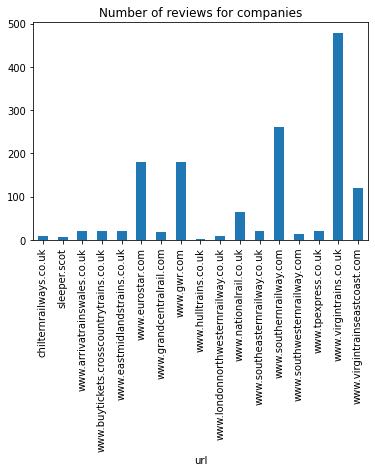

In [33]:
no_of_Reviews=df.groupby(['url']).size().plot.bar()
plt.title("Number of reviews for companies")
plt.show()

In [34]:
star_based_review_distr = df.groupby(['url', 'stars']).size()
reviewCountDF=pd.DataFrame(star_based_review_distr.reset_index(name = "review_count"))
reviewCountDF['percentage'] = 100 * reviewCountDF['review_count'] / reviewCountDF.groupby('url')['review_count'].transform('sum')
reviewCountDF


,url,stars,review_count,percentage
0,chilternrailways.co.uk,1,5,62.500000
1,chilternrailways.co.uk,4,3,37.500000
2,sleeper.scot,1,3,50.000000
3,sleeper.scot,3,1,16.666667
4,sleeper.scot,4,1,16.666667
5,sleeper.scot,5,1,16.666667
6,www.arrivatrainswales.co.uk,1,15,75.000000
7,www.arrivatrainswales.co.uk,2,2,10.000000
8,www.arrivatrainswales.co.uk,5,3,15.000000
9,www.buytickets.crosscountrytrains.co.uk,1,20,100.000000


Text(0, 0.5, 'Percentages')

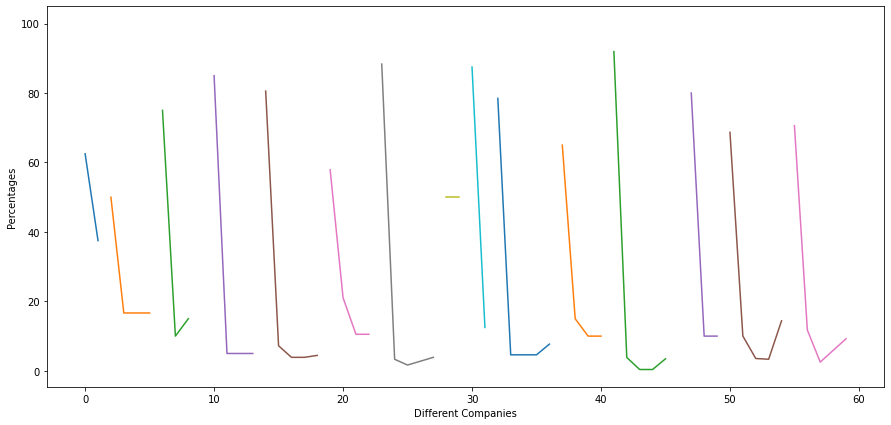

In [35]:
#reviewCountDF.set_index('Date', inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
reviewCountDF.groupby('url')['percentage'].plot(y='percentage',ax=ax)
ax.set_xlabel('Different Companies')
ax.set_ylabel('Percentages')

- www.buytickets.crosscountrytrains.co.uk only has negative reviews.All 1 star.  Total 20 reviews.
- www.southwesternrailway.com  also has all 1-star negative reviews. Total 13 reviews.
So, definitely these companies needs service improvement.

## Extracting the main topics people are talking about
Lets consider all reviews. And focus only on text field.

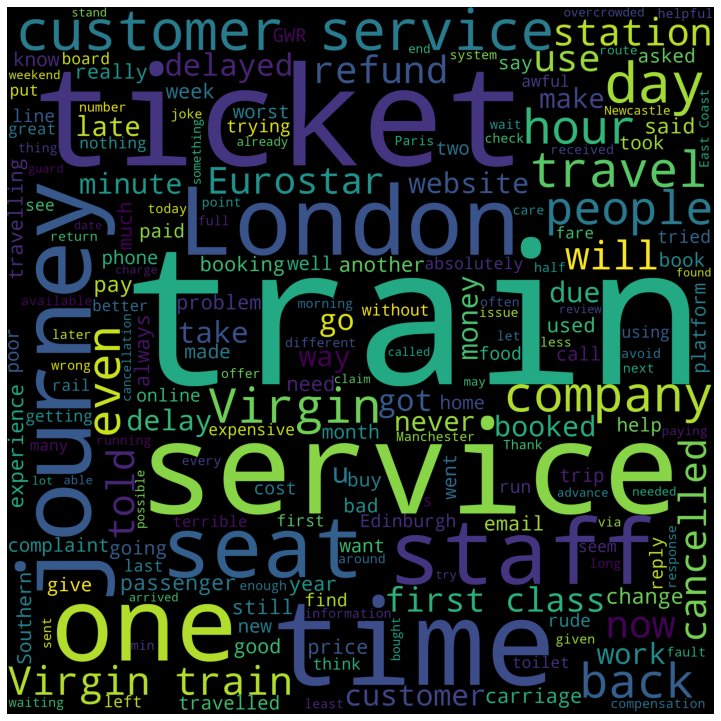

In [36]:
def showWordCloud(data):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color = 'black',
                         width = 2500,
                         height = 2500
                         ).generate(cleaned_word)
    plt.figure(1,figsize = (13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

showWordCloud(df['text'])

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(df['text'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram.head(30)

,frequency,bigram/trigram
0,185,customer service
1,154,first class
2,136,virgin trains
3,46,east coast
4,42,virgin train
5,38,southern rail
6,37,1st class
7,35,kings cross
8,34,get train
9,33,customer services


In [38]:
def clean_text(df):
    import spacy
    from nltk.stem.porter import PorterStemmer
    from nltk.corpus import wordnet
    from nltk.stem import WordNetLemmatizer 
    
    all_reviews = list()
    docs = df["text"].values.tolist()
    
    porter = PorterStemmer()
    #lines=["private?</p>"]
    nlp=spacy.load('en_core_web_sm')
   
    for text in docs:
         #Convert text to lower case
        text = text.lower()
        
        '''remove text in square brackets, remove html <> tags, remove punctuation and remove words containing numbers.'''
    
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('\<.*?\>', '', text)
        
        #text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", " ", text)
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
                       
        # Remove websites
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
             
            
        # Replace to full form
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        text = re.sub(r"wasnt", "was not", text)
        
        # Handling common domain specific bigram, trigrams
        # TODO: Need to automate bigram trigrams , and do it after lemmatizing the word
        text = re.sub(r"customer service", "customerservice", text)
        text = re.sub(r"customer services", "customerservice", text)
        text = re.sub(r"first class", "firstclass", text) 
        text = re.sub(r"virgin trains east coast", "virgintrainseastcoast", text)
        text = re.sub(r"virgin train east coast", "virgintrainseastcoast", text)
        text = re.sub(r"virgin trains", "virgintrain", text) 
        text = re.sub(r"virgin train", "virgintrain", text)
        text = re.sub(r"london north western railway", "londonnorthwesternrailway", text)
        text = re.sub(r"national rail", "nationalrail", text)
        text = re.sub(r"euro star", "eurostar", text)
        text = re.sub(r"south western railway", "southwesternrailway", text)
        text = re.sub(r"south eastern railway", "southeasternrailway", text)
        text = re.sub(r"hull train", "hulltrain", text)
        text = re.sub(r"cross country trains", "crosscountrytrains", text)
        text = re.sub(r"cross country", "crosscountry", text)
        text = re.sub(r"1st class", "1stclass", text)
        text = re.sub(r"southern rail", "southernrail", text)
        text = re.sub(r"next train", "nexttrain", text)
        text = re.sub(r"class ticket", "classticket", text)
        text = re.sub(r"web site", "website", text)                 
            
        #Tokenize to words
        tokens = word_tokenize(text)
        
        # remove words less than three letters
        tokens = [word for word in tokens if len(word) > 3]             
              
        # Removing stop words    
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        stop_words.update(["try","even","could","would"])
        tokens = [w for w in tokens if not w in stop_words]
        
        # Stem words to remove plurals etc
        #tokens = [porter.stem(word) for word in tokens]
        
        #Lemmatize       
        lmtzr = WordNetLemmatizer()
        tokens = [ lmtzr.lemmatize(token) for token in tokens ]
    
        #doc = ' '.join(tokens)
        doc=tokens
        all_reviews.append(doc)
    return all_reviews

reviews_doc = clean_text(df)
#showWordCloud(all_reviews)

In [39]:
from gensim.corpora import Dictionary
dictionary = Dictionary(reviews_doc)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in reviews_doc]
print('Number of unique terms: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique terms: 408
Number of documents: 1439


In [40]:
# Train LDA model.
from gensim.models import LdaModel
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, 
                    passes = 20, alpha='auto', eval_every = 400,random_state=1)


In [41]:
ldamodel.show_topics()

[(0,
  '0.033*"ticket" + 0.028*"price" + 0.026*"seat" + 0.023*"customerservice" + 0.019*"time" + 0.018*"virgin" + 0.018*"reply" + 0.018*"online" + 0.017*"booked" + 0.015*"full"'),
 (1,
  '0.064*"ticket" + 0.032*"website" + 0.027*"refund" + 0.025*"call" + 0.022*"change" + 0.021*"email" + 0.019*"time" + 0.018*"phone" + 0.018*"booking" + 0.016*"journey"'),
 (2,
  '0.049*"ticket" + 0.037*"journey" + 0.035*"return" + 0.028*"london" + 0.024*"still" + 0.023*"trip" + 0.019*"booked" + 0.018*"never" + 0.017*"edinburgh" + 0.016*"company"'),
 (3,
  '0.047*"staff" + 0.047*"station" + 0.025*"customerservice" + 0.023*"manager" + 0.020*"back" + 0.020*"rude" + 0.018*"london" + 0.018*"ticket" + 0.017*"passenger" + 0.015*"told"'),
 (4,
  '0.037*"seat" + 0.032*"time" + 0.027*"work" + 0.020*"really" + 0.017*"london" + 0.016*"cost" + 0.015*"travel" + 0.015*"price" + 0.014*"ticket" + 0.014*"change"'),
 (5,
  '0.034*"service" + 0.026*"people" + 0.025*"time" + 0.025*"company" + 0.022*"carriage" + 0.021*"seat" 

In [42]:
ldamodel.show_topics()

[(0,
  '0.033*"ticket" + 0.028*"price" + 0.026*"seat" + 0.023*"customerservice" + 0.019*"time" + 0.018*"virgin" + 0.018*"reply" + 0.018*"online" + 0.017*"booked" + 0.015*"full"'),
 (1,
  '0.064*"ticket" + 0.032*"website" + 0.027*"refund" + 0.025*"call" + 0.022*"change" + 0.021*"email" + 0.019*"time" + 0.018*"phone" + 0.018*"booking" + 0.016*"journey"'),
 (2,
  '0.049*"ticket" + 0.037*"journey" + 0.035*"return" + 0.028*"london" + 0.024*"still" + 0.023*"trip" + 0.019*"booked" + 0.018*"never" + 0.017*"edinburgh" + 0.016*"company"'),
 (3,
  '0.047*"staff" + 0.047*"station" + 0.025*"customerservice" + 0.023*"manager" + 0.020*"back" + 0.020*"rude" + 0.018*"london" + 0.018*"ticket" + 0.017*"passenger" + 0.015*"told"'),
 (4,
  '0.037*"seat" + 0.032*"time" + 0.027*"work" + 0.020*"really" + 0.017*"london" + 0.016*"cost" + 0.015*"travel" + 0.015*"price" + 0.014*"ticket" + 0.014*"change"'),
 (5,
  '0.034*"service" + 0.026*"people" + 0.025*"time" + 0.025*"company" + 0.022*"carriage" + 0.021*"seat" 

In [43]:
ldamodel.top_topics(corpus)

[([(0.069455646, 'ticket'),
   (0.020362847, 'virgin'),
   (0.018641097, 'told'),
   (0.017362112, 'said'),
   (0.016673138, 'staff'),
   (0.015474829, 'hour'),
   (0.014798209, 'time'),
   (0.012929969, 'journey'),
   (0.012866198, 'minute'),
   (0.0109196445, 'take'),
   (0.010708474, 'virgintrain'),
   (0.01055514, 'want'),
   (0.009791858, 'another'),
   (0.009762408, 'problem'),
   (0.00961451, 'went'),
   (0.009511367, 'make'),
   (0.009352217, 'people'),
   (0.00914136, 'rude'),
   (0.009110161, 'london'),
   (0.009086518, 'station')],
  -1.9206568598769387),
 ([(0.06378044, 'ticket'),
   (0.031811755, 'website'),
   (0.026903266, 'refund'),
   (0.02454809, 'call'),
   (0.021677395, 'change'),
   (0.021187034, 'email'),
   (0.01923875, 'time'),
   (0.018237177, 'phone'),
   (0.017642224, 'booking'),
   (0.015800925, 'journey'),
   (0.015029546, 'customer'),
   (0.014772428, 'card'),
   (0.014101267, 'book'),
   (0.012948092, 'day'),
   (0.012903695, 'travel'),
   (0.012053643, '

In [44]:
ldamodel.show_topics()

[(0,
  '0.033*"ticket" + 0.028*"price" + 0.026*"seat" + 0.023*"customerservice" + 0.019*"time" + 0.018*"virgin" + 0.018*"reply" + 0.018*"online" + 0.017*"booked" + 0.015*"full"'),
 (1,
  '0.064*"ticket" + 0.032*"website" + 0.027*"refund" + 0.025*"call" + 0.022*"change" + 0.021*"email" + 0.019*"time" + 0.018*"phone" + 0.018*"booking" + 0.016*"journey"'),
 (2,
  '0.049*"ticket" + 0.037*"journey" + 0.035*"return" + 0.028*"london" + 0.024*"still" + 0.023*"trip" + 0.019*"booked" + 0.018*"never" + 0.017*"edinburgh" + 0.016*"company"'),
 (3,
  '0.047*"staff" + 0.047*"station" + 0.025*"customerservice" + 0.023*"manager" + 0.020*"back" + 0.020*"rude" + 0.018*"london" + 0.018*"ticket" + 0.017*"passenger" + 0.015*"told"'),
 (4,
  '0.037*"seat" + 0.032*"time" + 0.027*"work" + 0.020*"really" + 0.017*"london" + 0.016*"cost" + 0.015*"travel" + 0.015*"price" + 0.014*"ticket" + 0.014*"change"'),
 (5,
  '0.034*"service" + 0.026*"people" + 0.025*"time" + 0.025*"company" + 0.022*"carriage" + 0.021*"seat" 

In [45]:
ldamodel.top_topics(corpus)

[([(0.069455646, 'ticket'),
   (0.020362847, 'virgin'),
   (0.018641097, 'told'),
   (0.017362112, 'said'),
   (0.016673138, 'staff'),
   (0.015474829, 'hour'),
   (0.014798209, 'time'),
   (0.012929969, 'journey'),
   (0.012866198, 'minute'),
   (0.0109196445, 'take'),
   (0.010708474, 'virgintrain'),
   (0.01055514, 'want'),
   (0.009791858, 'another'),
   (0.009762408, 'problem'),
   (0.00961451, 'went'),
   (0.009511367, 'make'),
   (0.009352217, 'people'),
   (0.00914136, 'rude'),
   (0.009110161, 'london'),
   (0.009086518, 'station')],
  -1.9206568598769387),
 ([(0.06378044, 'ticket'),
   (0.031811755, 'website'),
   (0.026903266, 'refund'),
   (0.02454809, 'call'),
   (0.021677395, 'change'),
   (0.021187034, 'email'),
   (0.01923875, 'time'),
   (0.018237177, 'phone'),
   (0.017642224, 'booking'),
   (0.015800925, 'journey'),
   (0.015029546, 'customer'),
   (0.014772428, 'card'),
   (0.014101267, 'book'),
   (0.012948092, 'day'),
   (0.012903695, 'travel'),
   (0.012053643, '

## TOPIC OVER TIME

In [46]:
df['year']=pd.DatetimeIndex(df['date']).year

In [47]:
df.loc[df['year']==2011]

,date,title,text,url,stars,year
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site when planning a rail journey. The site allows you to find the quickest route and the cheapest fare. It also has up to date information on travel disruptions.,www.nationalrail.co.uk,4,2011
1950,2011-11-20 20:43:09+00:00,"Reasonable prices, good service","First class is very spacious, free wireless internet, free food and hot drinks, food is reasonably nice. Staff very friendly.",www.hulltrains.co.uk,4,2011


In [48]:
df.groupby("year").size()

year
2011    2  
2015    68 
2016    287
2017    546
2018    536
dtype: int64

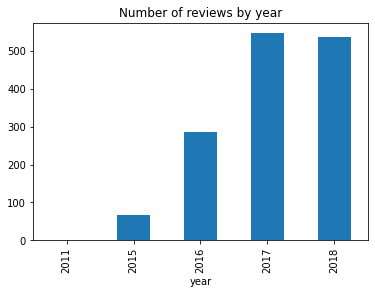

In [49]:
no_of_Reviews=df.groupby(['year']).size().plot.bar()
plt.title("Number of reviews by year")
plt.show()

In [50]:
# Each document is talking about which topics (and their probabilities)

topics_val = []
for document in corpus:
    topics_val.append(ldamodel.get_document_topics(document, minimum_probability=0.15, minimum_phi_value=None, per_word_topics=False))

In [51]:
df['topics'] = topics_val

In [52]:
df.topics.map(len).max()

4

<AxesSubplot:xlabel='year'>

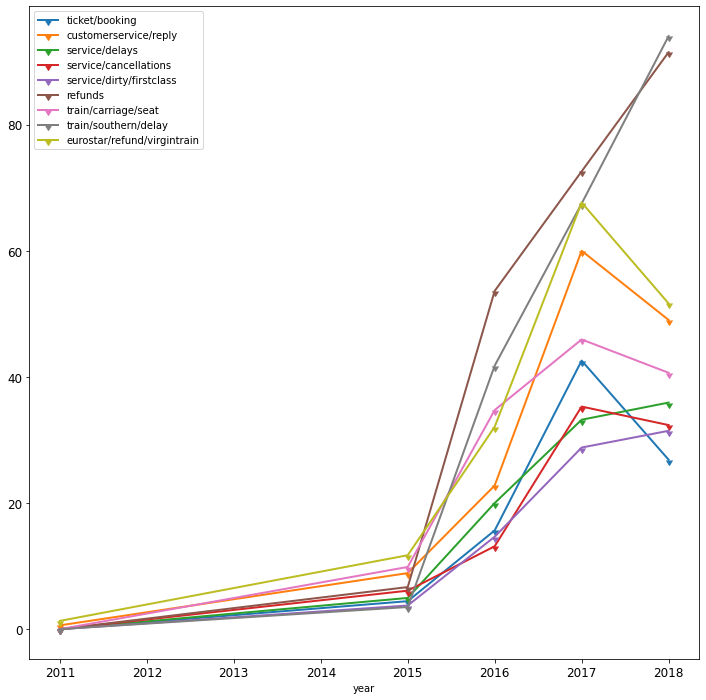

In [53]:
topics = {
    0: 'ticket/booking',
    1: 'customerservice/reply',
    2: 'service/delays',
    3: 'service/cancellations',
    4: 'service/dirty/firstclass',
    5: 'refunds',
    6: 'train/carriage/seat',
    7: 'train/southern/delay',
    8: 'eurostar/refund/virgintrain',
    9: 'staff/cost/travel'
}
df_with_topics = df
import numpy as np
for t in np.arange(0,9):
    df_with_topics[topics[t]] = [[i[1] if i[0]==t else 0 for i in a] for a in df_with_topics['topics']]
    df_with_topics[topics[t]] = [[i for i in a if i > 0] for a in df_with_topics[topics[t]]]
    df_with_topics[topics[t]] = df_with_topics[topics[t]].apply(lambda x: 0 if len(x)==0 else x[0])
df_with_topics.sort_values(by='topics',inplace=True)
year_distribution = df_with_topics.drop(['date','title','text','url','stars','topics'],axis=1)
year_distribution = year_distribution.groupby('year').sum()
year_distribution.plot(linewidth=2, fontsize=12, figsize=(12,12), marker=11)

## Model2: GSDMM Model (as the review length is usually small)

In [54]:
df=data_clean
data=data_clean["text"]


In [55]:
df.stars.unique()

array(['5', '4', '1', '2', '3'], dtype=object)

In [56]:
#from gsdmm import MovieGroupProcess
import gensim
import spacy
import numpy as np

#turning sentences into words

data_words =[]
for doc in data:
    doc = doc.split()
    data_words.append(doc)
vocabulary=data_words

#building bi-grams 

bigram = gensim.models.Phrases(vocabulary, min_count=5, threshold=100) 

bigram_mod = gensim.models.phrases.Phraser(bigram)

print('done!')



# Removing stop Words
stop_words = set(stopwords.words("english"))
#add words that aren't in the NLTK stopwords list
#domain_specific = (['try'])
#stop_words=stop_words.extend(domain_specific)
stop_words.update(["try","even","could","would"])
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(vocabulary)


# Form Bigrams
data_words_bigrams = [bigram_mod[doc] for doc in data_words_nostops]



#lemmatization
#nlp = spacy.load("en_core_web_sm")
nlp=spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = []
for sent in data_words_bigrams:
    doc = nlp(" ".join(sent)) 
    data_lemmatized.append([token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])

docs = data_lemmatized
vocab = set(x for doc in docs for x in doc)


# Train a new model 
import random
random.seed(1000)
# Init of the Gibbs Sampling Dirichlet Mixture Model algorithm
mgp = MovieGroupProcess(K=7, alpha=0.1, beta=0.1, n_iters=25)

vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
n_docs = len(docs)

# Fit the model on the data given the chosen seeds
y = mgp.fit(docs, n_terms)

            
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)


# Show the top 10 words in term frequency for each cluster 
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — — ')
top_words(mgp.cluster_word_distribution, top_index, 20)



done!
In stage 0: transferred 1106 clusters with 7 clusters populated
In stage 1: transferred 670 clusters with 7 clusters populated
In stage 2: transferred 478 clusters with 7 clusters populated
In stage 3: transferred 399 clusters with 7 clusters populated
In stage 4: transferred 358 clusters with 7 clusters populated
In stage 5: transferred 318 clusters with 7 clusters populated
In stage 6: transferred 282 clusters with 7 clusters populated
In stage 7: transferred 273 clusters with 7 clusters populated
In stage 8: transferred 255 clusters with 7 clusters populated
In stage 9: transferred 273 clusters with 7 clusters populated
In stage 10: transferred 244 clusters with 7 clusters populated
In stage 11: transferred 246 clusters with 7 clusters populated
In stage 12: transferred 235 clusters with 7 clusters populated
In stage 13: transferred 205 clusters with 7 clusters populated
In stage 14: transferred 203 clusters with 7 clusters populated
In stage 15: transferred 210 clusters with 

In [57]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
               'type 7'
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [58]:
top_index

array([6, 0, 1, 4, 5, 3, 2], dtype=int64)

In [59]:
topic_dict

{6: 'type 1',
 0: 'type 2',
 1: 'type 3',
 4: 'type 4',
 5: 'type 5',
 3: 'type 6',
 2: 'type 7'}

In [60]:
df.date[i]

Timestamp('2018-03-06 11:53:42+0000', tz='UTC')

In [61]:
data_text=enumerate(df["text"])
df['date'][70]
df.stars.iloc[71]

'1'

In [62]:
def create_topics_dataframe(data_text=df,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=data_lemmatized):
    result = pd.DataFrame(columns=['date','text', 'topic', 'stars', 'lemma-text','probability'])
    data_text=df["text"]
    for i, text in enumerate(data_text):
        result.at[i, 'date'] = df.date.iloc[i]
        result.at[i, 'text'] = text
        result.at[i, 'stars'] = df.stars.iloc[i]
        result.at[i, 'lemma-text'] = data_lemmatized[i]        
        prob = mgp.choose_best_label(data_lemmatized[i])
        result.at[i, 'probability'] = prob[1]
        #print("Probability:",i,prob)
        if (prob[1] >= threshold and prob[1] != 1.0):
            result.at[i, 'topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'topic'] = 'Other'
    return result

In [63]:
result = create_topics_dataframe(data_text=df, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=data_lemmatized)


Probability: 0 (5, 0.6827998274644417)
Probability: 1 (6, 0.7792218538712203)
Probability: 2 (6, 0.3939015072584567)
Probability: 3 (0, 0.8436364858070144)
Probability: 4 (6, 0.4143785113356886)
Probability: 5 (3, 0.9355479563687316)
Probability: 6 (0, 0.9333640431859065)
Probability: 7 (6, 0.5483233572571932)
Probability: 8 (0, 0.6677231615570746)
Probability: 9 (6, 0.7782662532979853)
Probability: 10 (5, 0.4815404437206429)
Probability: 11 (6, 0.3939015072584567)
Probability: 12 (4, 0.6372050244556747)
Probability: 13 (0, 0.7513117596570728)
Probability: 14 (4, 0.6029952279657566)
Probability: 15 (6, 0.3939015072584567)
Probability: 16 (6, 0.6180008703846357)
Probability: 17 (6, 0.5641678936631647)
Probability: 18 (5, 0.36921151814535)
Probability: 19 (5, 0.964965408283379)
Probability: 20 (6, 0.3939015072584567)
Probability: 21 (6, 0.3939015072584567)
Probability: 22 (4, 0.7196247925426869)
Probability: 23 (6, 0.3939015072584567)
Probability: 24 (1, 1.0)
Probability: 25 (6, 0.999997

In [64]:
result.topic.unique()

array(['type 5', 'type 1', 'type 2', 'type 6', 'type 4', 'Other',
       'type 3', 'type 7'], dtype=object)

<AxesSubplot:xlabel='date', ylabel='stars'>

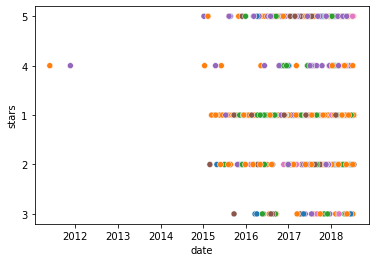

In [67]:
sns.scatterplot(data=result, x="date", y="stars",hue="topic",legend=False)

In [68]:
result['year']=pd.DatetimeIndex(df['date']).year

<AxesSubplot:xlabel='year'>

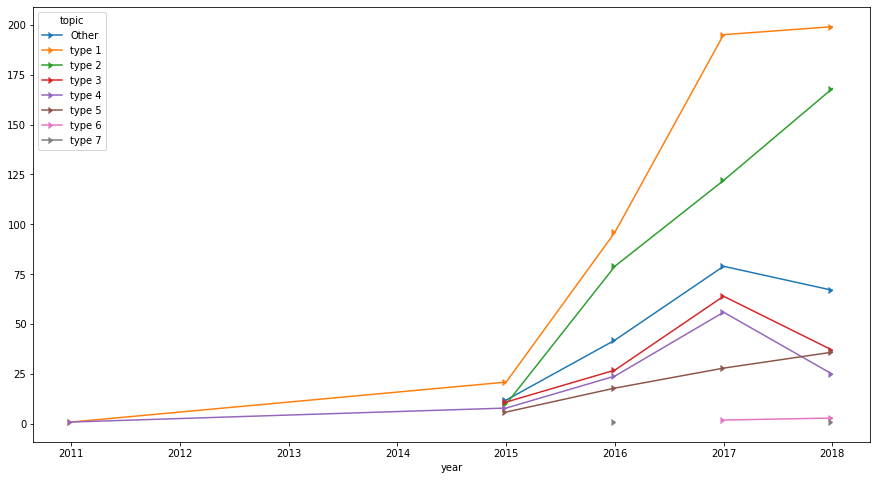

In [69]:
#result['year']=pd.DatetimeIndex(result['date']).year
year_distribution = result.drop(['date','text','stars','lemma-text','probability'],axis=1)
year_distribution.groupby(['year','topic']).size().unstack().plot(figsize=(15,8),marker=5)

### Conclusion about GSDMM
GSDMM gives more cohesive clusters and also highlights how some topics are highly discussed. It 
finds small clusters as well where something different was been discussed. e.g. tunnel issues were seen here only in 2017 only.

## Future work

- Depending on imbalanced dataset, maybe positive and negative topics can be analyzed separately.
- Research on TOT , or LDA online


## TRAIN SERVICE SHOULD KNOW.

    - Only 2 reviews from 2011. And then 2015 onwards.
    - Following companies are notorios in reviews:
        - www.buytickets.crosscountrytrains.co.uk only has 1-star reviews (Total 20 reviews). 
        - www.southwesternrailway.com  also has all 1-star negative reviews. (Total 13 reviews).
        
    - "https://uk.trustpilot.com/review/www.nationalrail.co.uk" has many duplicated reviews on trust pilot, so that should be investigated.
    
    
    
    - From baseline LDA, these are the topics mainly. 
        * People are unhappy about customer service, rude staff, website issues, train delays need to be improved, eurostar and virgintrains are mostly negatively mentioned (more reviews too),in eurostar probably the staff replies late, booking issues.    
 
    
    - With gsdmm (on title):
        * bad customer service and bad experience
        * website issues.
        * trains experience time delays
        * Some new website is useless and is having booking issues
        * First class passengers are happy with free sausage and good food offered.
        * Some company website is quite old and price is expensive.
        * Some reviews regarding toilet and seat.
        
      - With gsdm (on reviews) 
        * Majority of the people are talking about customer service not being good and are unhappy with the staff.
        * Facing booking issues on websites.
        * Unhappy about train delays.
        * Refund issues, emailing, calling etc.
        * Some happy customers talking about getting seats, good food and toilets.
        * First class passengers are quite happy with food.
        * A small group is unhappy about some tunnel work thats ongoing. This topic is new and is discussed only in 2017.
        
       
    

MORE EDA: (can be done later)

TODO: Length of reviews

TODO: Customer category of stars plot imporvement needed.


TODO: LDA hyper parameter tuning.

TODO: More review companies can be filtered and then LDA can be applied.

TODO: Positive review LDA

TODO: Negative reviews LDA

TODO: Include lemmatization


Main things:

TODO: Each review assigned to which topic , and then see the trend over time.
TODO: Take2: LDA applied on years.


